In [1]:
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/code_states/s4_project'

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import pickle

In [3]:
# checkpoint 불러오기 ( 저장된 파일 확인 )
with open(path + '/audio_df_01_spt.pickle', 'rb') as f:
    spt = pickle.load(f)
with open(path + '/audio_df_01_note_list.pickle', 'rb') as f:
    note_list = pickle.load(f)

In [4]:
len(spt), len(note_list), len(set(note_list))

(19200, 19200, 50)

### Scaler : MinMaxScaler<br/> LabelEncoder : 0부터 시작하지 않기 때문에 인코더 적용

In [5]:
spt = np.array(spt)

In [6]:
# MinMaxScaler와 같은 방식으로 scaling.
spt_max = np.max(spt)
spt_min = np.min(spt)
spt_scaled = (spt - spt_min) / (spt_max - spt_min)
spt_max, spt_min, spt_scaled.min(), spt_scaled.max()

(13.270682392935731, 0.0, 0.0, 1.0)

In [7]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
note_label = encoder.fit_transform(note_list)
note_label.min(), note_label.max()

(0, 49)

### split train, test case

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(spt_scaled, note_label, test_size=0.2, stratify=note_list) # spt로 ins 추측
X_train.shape, X_test.shape

((15360, 168, 87), (3840, 168, 87))

### 모델링

In [9]:
import keras
from tensorflow.keras import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model

In [10]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

input_shape

(168, 87, 1)

In [11]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.5))

model.add(Conv2D(64, kernel_size=(3,3), strides=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation="relu"))

model.add(Dense(256, activation="relu"))

model.add(Dense(50, activation="softmax"))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 168, 87, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 168, 87, 32)       4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 43, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 11, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 21, 11, 64)        0

In [13]:
from keras.models import load_model

class save(keras.callbacks.Callback):
 def __init__(self, model):
  self.count = 0
  self.model = model

 def on_epoch_end(self, bath, logs={}):
  self.count = self.count + 1
  if self.count % 10 == 0:
   model.save("mymodel_epoch_{}.h5".format(self.count))

In [14]:
s = save(model)
es = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint('best_model_note.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[es, mc])

Epoch 1/30
480/480 [==============================] - 35s 48ms/step - loss: 3.5419 - accuracy: 0.0352 - val_loss: 3.3159 - val_accuracy: 0.0406
Epoch 2/30
480/480 [==============================] - 23s 49ms/step - loss: 3.2663 - accuracy: 0.0574 - val_loss: 3.2546 - val_accuracy: 0.0492
Epoch 3/30
480/480 [==============================] - 23s 49ms/step - loss: 3.1360 - accuracy: 0.0928 - val_loss: 3.1278 - val_accuracy: 0.0922
Epoch 4/30
480/480 [==============================] - 22s 46ms/step - loss: 2.8840 - accuracy: 0.1701 - val_loss: 2.9492 - val_accuracy: 0.1500
Epoch 5/30
480/480 [==============================] - 22s 45ms/step - loss: 2.5332 - accuracy: 0.2721 - val_loss: 2.6025 - val_accuracy: 0.2526
Epoch 6/30
480/480 [==============================] - 22s 45ms/step - loss: 2.0859 - accuracy: 0.3972 - val_loss: 2.2000 - val_accuracy: 0.3826
Epoch 7/30
480/480 [==============================] - 23s 48ms/step - loss: 1.6543 - accuracy: 0.5174 - val_loss: 1.7913 - val_accuracy:

In [15]:
result = model.evaluate(X_test, y_test, batch_size=64)
print('test loss, test acc:', result)

60/60 [==============================] - 2s 24ms/step - loss: 0.5231 - accuracy: 0.9242
test loss, test acc: [0.5230833888053894, 0.9242187738418579]


In [16]:
y_pred = model.predict(X_test)
len(X_test), len(y_pred), len(y_pred[0])

(3840, 3840, 50)

In [17]:
y_pred_index = []
for data in y_pred :
  y_pred_index.append(np.argmax(data))
len(y_pred_index)

3840

### 성능 평가

정확도 ( Accuracy )<br/>
오차 행렬 ( Confusion Matrix )<br/>
정밀도 ( Precision )<br/>
재현율 ( Recall )<br/>
F1-score : 불균형 여부 확인. 높을수록 좋다.acc와 비교 ( inbalanced한 데이터일 경우 차이가 크다 )<br/>
ROC : 임계값 확인<br/>
AUC : ROC 곡선 밑의 면적. 1에 가까울수록 좋다.<br/>

In [18]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score

print("accuracy_score : ",accuracy_score(y_test, y_pred_index))
print("recall_score : ",recall_score(y_test, y_pred_index, average='macro'))
print("precision_score : ",precision_score(y_test, y_pred_index, average='macro'))
print("f1_score : ",f1_score(y_test, y_pred_index, average='macro'))

accuracy_score :  0.92421875
recall_score :  0.9242447026657554
precision_score :  0.9362207285115022
f1_score :  0.9271669212174506


In [19]:
print(classification_report(y_test, y_pred_index))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90        77
           1       0.95      1.00      0.97        76
           2       1.00      0.94      0.97        77
           3       0.96      0.87      0.91        77
           4       0.99      0.86      0.92        77
           5       1.00      0.86      0.92        77
           6       0.94      0.84      0.89        77
           7       0.91      0.96      0.94        77
           8       0.96      0.95      0.95        77
           9       0.90      0.96      0.93        76
          10       1.00      0.82      0.90        77
          11       0.96      0.91      0.93        77
          12       0.94      0.82      0.88        77
          13       0.97      0.97      0.97        77
          14       0.96      0.96      0.96        76
          15       0.99      0.90      0.94        77
          16       0.48      1.00      0.65        77
          17       0.99    

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

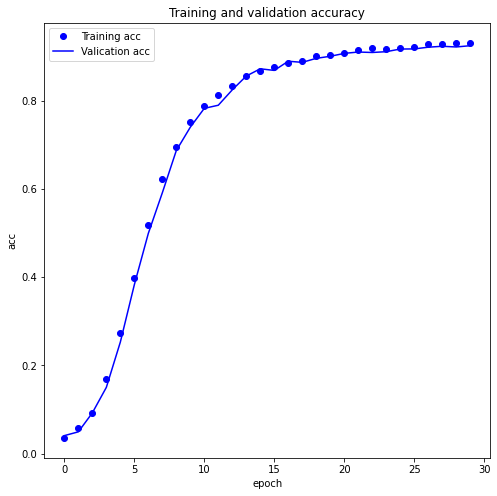

In [22]:
import matplotlib.pyplot as plt
# 정확도
plt.figure(figsize=(8,8))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Valication acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

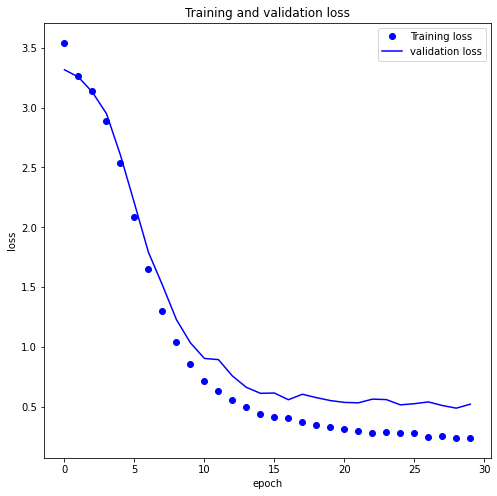

In [23]:
# loss
plt.figure(figsize=(8,8))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

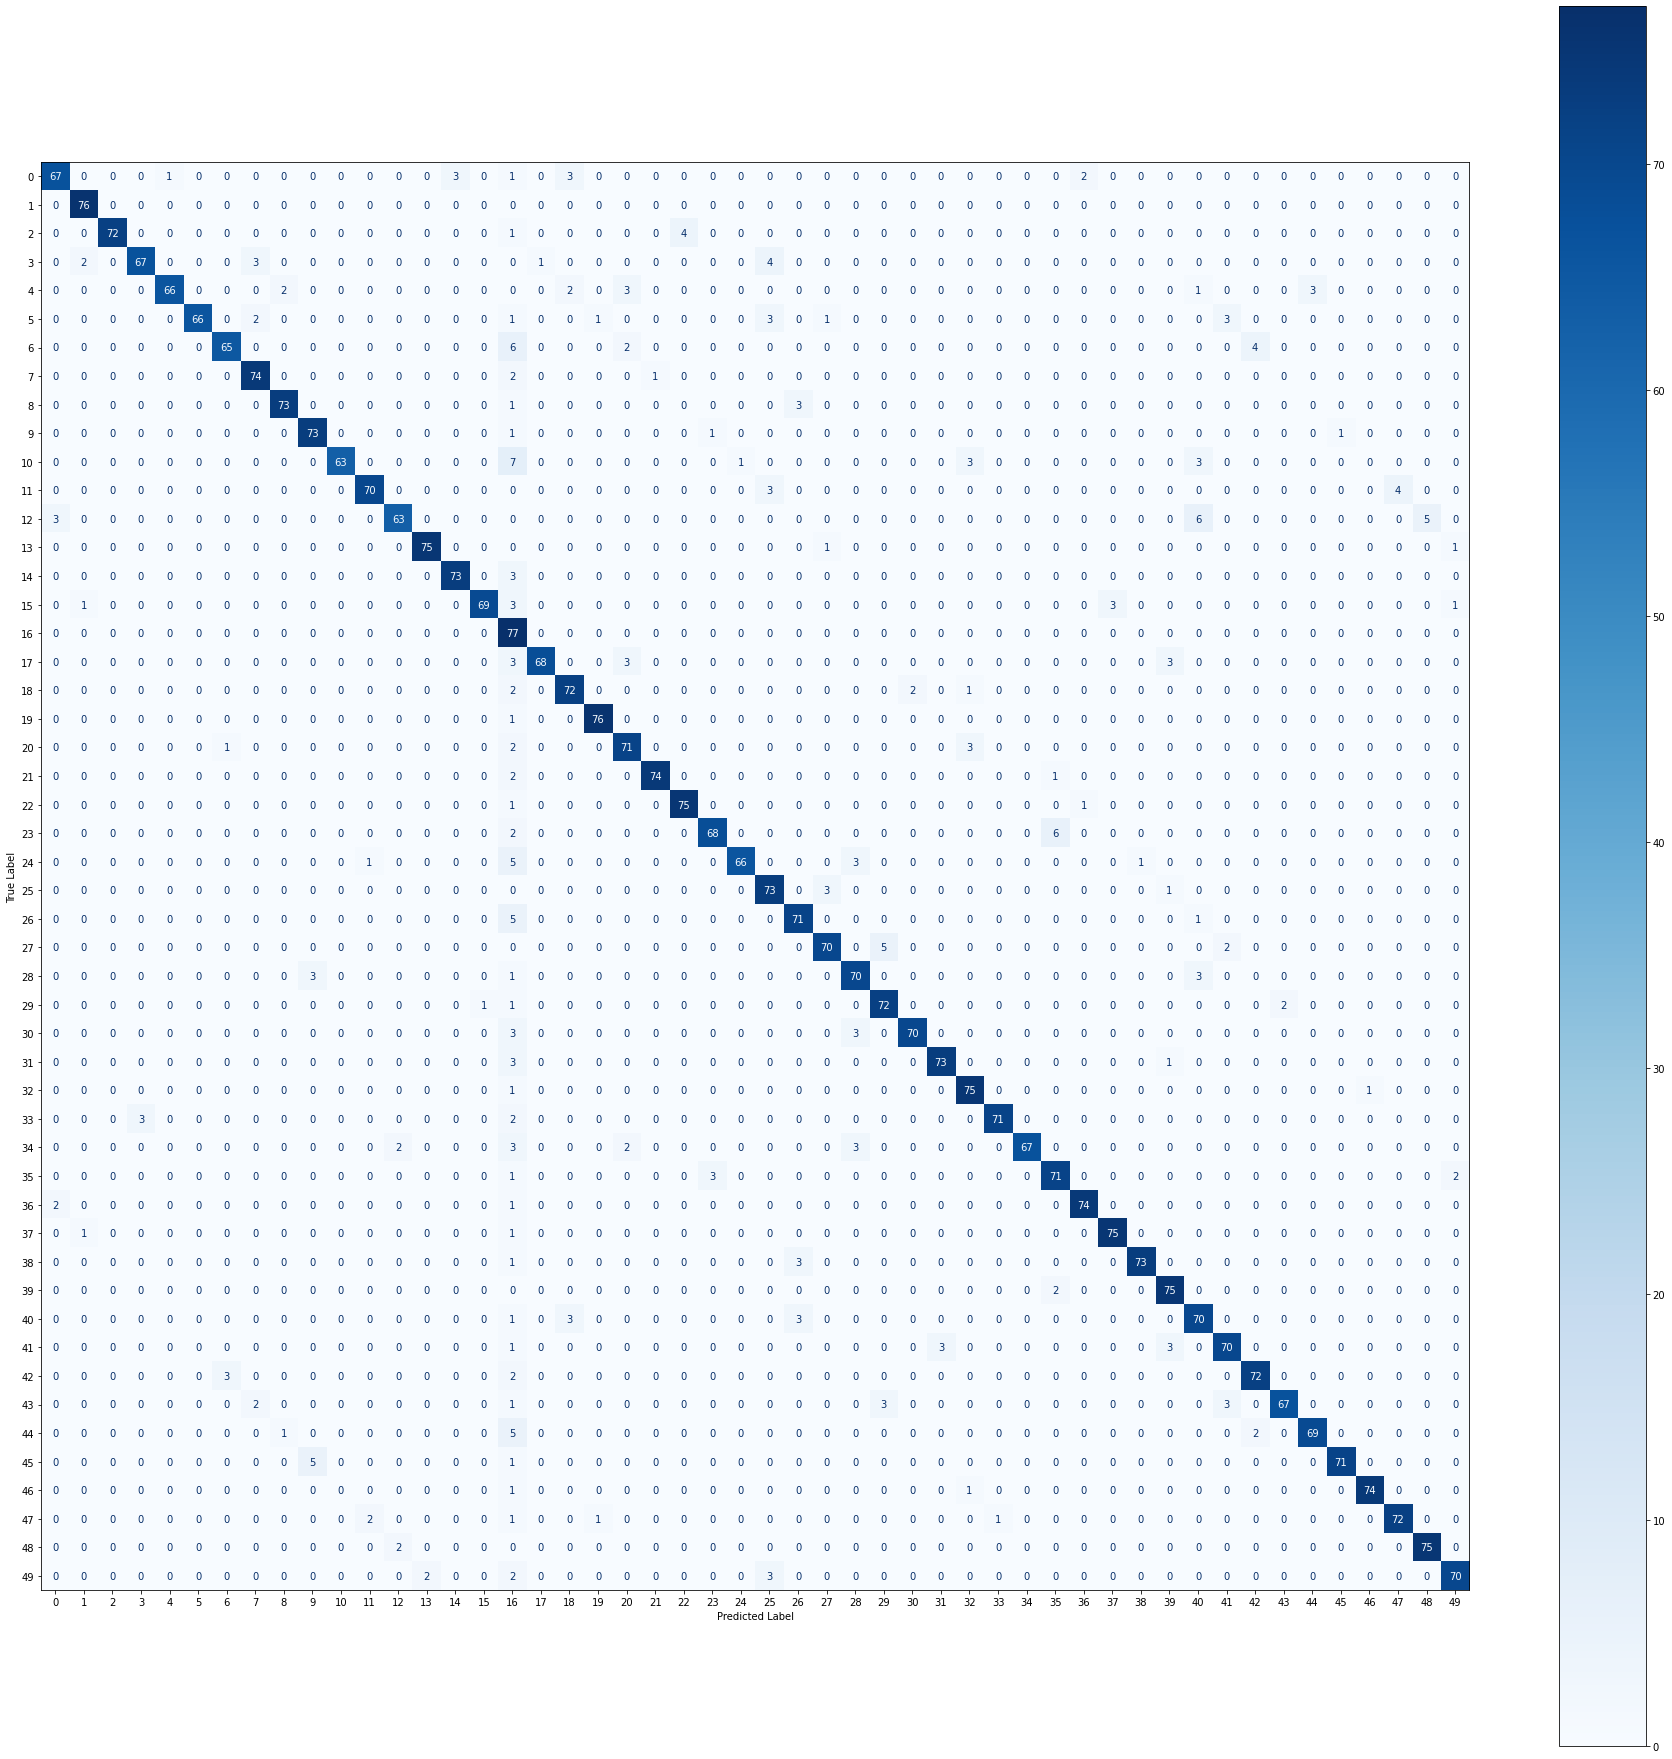

In [24]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
# 오차행렬
cm = confusion_matrix(y_test, y_pred_index)

plt.figure(figsize=(32,32))
ax = plt.gca()
disp = confusion_matrix(y_test, y_pred_index)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [25]:
with open(path + '/classify_note_model.pickle', 'wb') as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://1a6ef0fc-becf-45dd-a1ff-0fe74cc09d69/assets


### 데이터 확인

In [26]:
# # 불러오기
# with open(path + '/classify_note_model.pickle', 'rb') as f:
#     model = pickle.load(f)

In [34]:
print(y_test[0], encoder.inverse_transform([y_test[0]]))
print(y_train.max(), y_train.min())
encoder.inverse_transform([y_train.min(), y_train.max()])

42 [80]
49 0


array([38, 87])